In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import re
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
import nltk
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from gensim.models import CoherenceModel

df = pd.read_csv("cleaned_reviews.csv")
nltk.download("wordnet")
nltk.download("vader_lexicon")





















[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100
reviews = []

for i in range(1, pages + 1):
    print(f"Scraping page {i}")
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    response = requests.get(url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    print(f"   ---> {len(reviews)} total reviews")


In [ ]:

df = pd.DataFrame()
df["reviews"] = reviews

df = df[df['reviews'].notnull()]


df['reviews'] = df['reviews'].str.strip()
df['reviews'] = df['reviews'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

df["reviews"] = df["reviews"].str.replace(r"(trip verified|not verified)", "", flags=re.IGNORECASE, regex=True).str.strip()
df['reviews'] = df['reviews'].str.lower()
df = df.drop_duplicates()


print(df.head())  



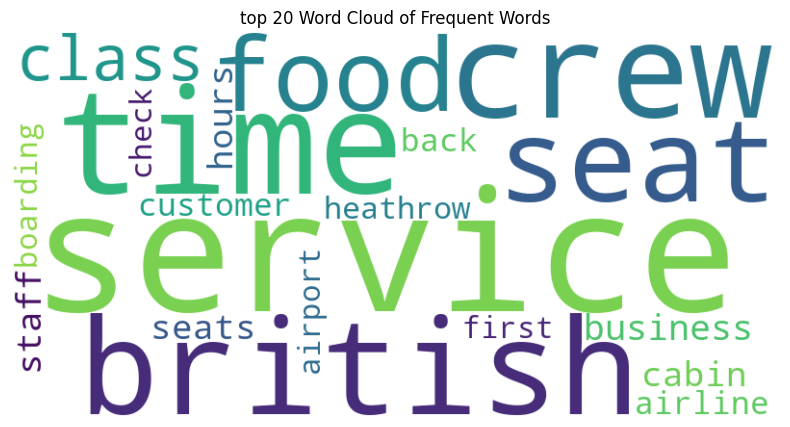

Counter({'service': 735, 'time': 543, 'crew': 457, 'british': 447, 'seat': 442, 'food': 437, 'class': 429, 'business': 405, 'staff': 385, 'seats': 378, 'hours': 371, 'cabin': 370, 'back': 315, 'customer': 309, 'airline': 306, 'heathrow': 292, 'check': 275, 'first': 273, 'airport': 270, 'boarding': 263, 'experience': 258, 'passengers': 250, 'plane': 239, 'economy': 238, 'hour': 234, 'cancelled': 225, 'club': 222, 'fly': 220, 'luggage': 219, 'minutes': 206, 'never': 205, 'return': 205, 'booked': 202, 'got': 200, 'another': 199, '2': 198, 'lounge': 195, 'new': 195, 'still': 193, 'due': 191, '3': 184, 'also': 184, 'like': 182, 'meal': 182, 'aircraft': 181, 'day': 181, 'really': 174, 'delayed': 174, 'airlines': 174, 'two': 172, 'arrived': 170, 'gate': 164, 'made': 163, 'next': 162, 'well': 159, 'offered': 158, 'late': 157, 'said': 156, 'people': 155, 'call': 155, 'days': 154, 'took': 152, 'long': 150, 'bag': 148, 'great': 147, 'given': 147, 'flying': 146, 'much': 145, 'make': 143, 'way': 14

In [2]:
stop_words = set(stopwords.words("english"))
all_text = " ".join(df["reviews"].tolist()).split()
additional_stopwords = {"verified", "ba", "trip", "us", "london", "airways", "would", "get","good","told","even","flights","could","one", "flight"}
stop_words.update(additional_stopwords)
filtered_words = [word for word in all_text if word.lower() not in stop_words]
freq_word = Counter(filtered_words)

top_20_word = dict(freq_word.most_common(20))

words = list(top_20_word.keys()) 
frequencies = list(top_20_word.values()) 


wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_20_word)
plt.figure(figsize=(50, 5))
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off')  
plt.title("top 20 Word Cloud of Frequent Words")  
plt.show()  

print(freq_word)
print(type(freq_word))



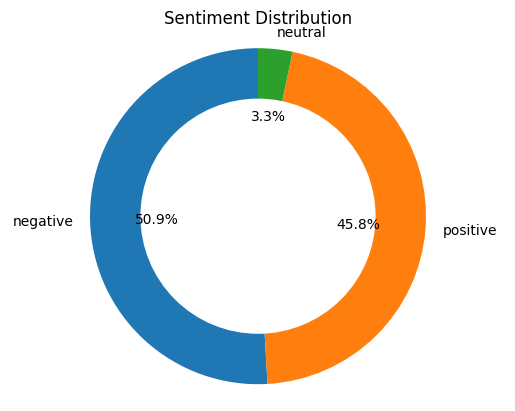

0      positive
1      positive
2      negative
3      negative
4      positive
         ...   
995    negative
996    positive
997    negative
998    negative
999    positive
Name: sentiment_label, Length: 1000, dtype: object


In [3]:

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return sia.polarity_scores(text)["compound"]


def label_sentiment(score):
    if score > 0.1:
        return "Positive"
    elif score < -0.1:
        return "Negative"
    else:
        return "Neutral"


df["sentiment"] = df["reviews"].apply(get_sentiment)

df["sentiment_label"] = df["sentiment"].apply(label_sentiment).str.lower()

# Hitung distribusi sentiment
sentiment_counts = df["sentiment_label"].value_counts()

# Plot pie chart
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title("Sentiment Distribution")
plt.axis('equal')
plt.show()

print(df["sentiment_label"] )







In [6]:
stop_words = set(stopwords.words("english"))
additional_stopwords = {
    "verified", "ba", "trip", "us", "london", "airways", "would", "get",
    "good", "told", "even", "flights", "could", "one", "flight"
}
stop_words.update(additional_stopwords) 
lemmatizer = WordNetLemmatizer()
all_reviews = df['reviews'].tolist()  

processed_reviews = []
for review in all_reviews:
    tokens = word_tokenize(review.lower())  
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    processed_reviews.append(filtered_tokens)

  
# print(filtered_tokens)

dictionary = corpora.Dictionary(processed_reviews)

corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# print(corpus)
# print(type(dictionary))

lda = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15, random_state=2)

topics = lda.print_topics(num_words=5)  
for topic in topics:
    print(topic)


(0, '0.011*"customer" + 0.011*"service" + 0.010*"airline" + 0.008*"british" + 0.008*"hour"')
(1, '0.013*"hour" + 0.008*"luggage" + 0.008*"seat" + 0.008*"time" + 0.007*"service"')
(2, '0.016*"seat" + 0.013*"crew" + 0.012*"food" + 0.011*"service" + 0.010*"cabin"')


In [15]:
coherence_scores = []

# Loop untuk mencoba random_state dari 1 sampai 20
for rs in range(1, 21):
    lda = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=5, random_state=rs)
    
    # Menghitung coherence score untuk model LDA
    coherence_model_lda = CoherenceModel(model=lda, texts=processed_reviews, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    
    # Menyimpan random_state dan coherence score
    coherence_scores.append((rs, coherence_score))

# Menampilkan hasil random_state dan coherence score untuk 1-20
for rs, score in coherence_scores:
    print(f"Random State {rs}: Coherence Score = {score}")


Random State 1: Coherence Score = 0.38384926275279846
Random State 2: Coherence Score = 0.3755742969685552
Random State 3: Coherence Score = 0.3173700025870097
Random State 4: Coherence Score = 0.3328811785646804
Random State 5: Coherence Score = 0.3765356822724084
Random State 6: Coherence Score = 0.37624896416736103
Random State 7: Coherence Score = 0.3511899352399223
Random State 8: Coherence Score = 0.3370364439045888
Random State 9: Coherence Score = 0.3590430406099148
Random State 10: Coherence Score = 0.36057360168257907
Random State 11: Coherence Score = 0.37639473731343714
Random State 12: Coherence Score = 0.39437853351616914
Random State 13: Coherence Score = 0.3621322335913147
Random State 14: Coherence Score = 0.3844941289413284
Random State 15: Coherence Score = 0.3710155633666424
Random State 16: Coherence Score = 0.2768095888699621
Random State 17: Coherence Score = 0.3510271654113548
Random State 18: Coherence Score = 0.3782909809218234
Random State 19: Coherence Score

In [7]:
top_topic_freq = Counter()

for bow in corpus:
    topics = lda.get_document_topics(bow)
    top_topic = max(topics, key=lambda x: x[1])[0]
    top_topic_freq[top_topic] += 1

print(top_topic_freq)

Counter({2: 450, 0: 293, 1: 257})


In [8]:
topic_sentiment_count = defaultdict(lambda: {'positive': 0, 'neutral': 0, 'negative': 0})


for i, bow in enumerate(corpus):
    sentiment = df.loc[i, 'sentiment_label']
    topics = lda.get_document_topics(bow)
    top_topic = max(topics, key=lambda x: x[1])[0]
    topic_sentiment_count[top_topic][sentiment] += 1


for topic, sentiment_counts in topic_sentiment_count.items():
    print(f"Topic {topic}: {sentiment_counts}")

Topic 2: {'positive': 317, 'neutral': 9, 'negative': 124}
Topic 0: {'positive': 70, 'neutral': 16, 'negative': 207}
Topic 1: {'positive': 71, 'neutral': 8, 'negative': 178}


In [ ]:
# df.to_csv('cleaned_reviews.csv', index=True)
